<a href="https://www.kaggle.com/code/vainero/sonar-mines-vs-rocks-binary-classification?scriptVersionId=110876816" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://github.com/vainero/Files/blob/main/S_mines.gif?raw=true">


<h1 style="color:#3f8088; font-style:italic; font-family:Cursive;"> <center>Thanks for visiting my notebook</center> </h1>

<h2 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center>Data Exploration</center></h2> 

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
        
* The focus of this project is the Sonar Mines vs Rocks dataset.
* The problem is to predict metal or rock objects from sonar return data.
* Each pattern is a set of 60 numbers in the range 0.0 to 1.0. 
* Each number represents the energy within a particular frequency band, integrated over a certain period of time.
* The label associated with each record contains the letter R if the object is a rock and M if it is a mine (metal cylinder). 
* The numbers in the labels are in increasing order of aspect angle, but they do not encode the angle directly. 

<a id = 'title-one'></a>     
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Import Libraries </center></h1> 


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier


%matplotlib inline

import warnings
warnings.filterwarnings("ignore") 

# Custom colors
class clr:
    S = '\033[1m' + '\033[36m'
    E = '\033[0m' 

<a id = 'title-two'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Loading Data </center></h1> 

In [2]:
df = pd.read_csv('../input/sonar-mine-dataset/sonar data.csv', header = None)
# Display the data
df.head().style.background_gradient(cmap='PuBuGn').set_properties(**{'font-style': 'italic',
                                                                   'font-family': 'Cursive'}).hide_index()

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0.020000,0.037100,0.042800,0.020700,0.095400,0.098600,0.153900,0.160100,0.310900,0.211100,0.160900,0.158200,0.223800,0.064500,0.066000,0.227300,0.310000,0.299900,0.507800,0.479700,0.578300,0.507100,0.432800,0.555000,0.671100,0.641500,0.710400,0.808000,0.679100,0.385700,0.130700,0.260400,0.512100,0.754700,0.853700,0.850700,0.669200,0.609700,0.494300,0.274400,0.051000,0.283400,0.282500,0.425600,0.264100,0.138600,0.105100,0.134300,0.038300,0.032400,0.023200,0.002700,0.006500,0.015900,0.007200,0.016700,0.018000,0.008400,0.009000,0.003200,R
0.045300,0.052300,0.084300,0.068900,0.118300,0.258300,0.215600,0.348100,0.333700,0.287200,0.491800,0.655200,0.691900,0.779700,0.746400,0.944400,1.000000,0.887400,0.802400,0.781800,0.521200,0.405200,0.395700,0.391400,0.325000,0.320000,0.327100,0.276700,0.442300,0.202800,0.378800,0.294700,0.198400,0.234100,0.130600,0.418200,0.383500,0.105700,0.184000,0.197000,0.167400,0.058300,0.140100,0.162800,0.062100,0.020300,0.053000,0.074200,0.040900,0.006100,0.012500,0.008400,0.008900,0.004800,0.009400,0.019100,0.014000,0.004900,0.005200,0.004400,R
0.026200,0.058200,0.109900,0.108300,0.097400,0.228000,0.243100,0.377100,0.559800,0.619400,0.633300,0.706000,0.554400,0.532000,0.647900,0.693100,0.675900,0.755100,0.892900,0.861900,0.797400,0.673700,0.429300,0.364800,0.533100,0.241300,0.507000,0.853300,0.603600,0.851400,0.851200,0.504500,0.186200,0.270900,0.423200,0.304300,0.611600,0.675600,0.537500,0.471900,0.464700,0.258700,0.212900,0.222200,0.211100,0.017600,0.134800,0.074400,0.013000,0.010600,0.003300,0.023200,0.016600,0.009500,0.018000,0.024400,0.031600,0.016400,0.009500,0.007800,R
0.010000,0.017100,0.062300,0.020500,0.020500,0.036800,0.109800,0.127600,0.059800,0.126400,0.088100,0.199200,0.018400,0.226100,0.172900,0.213100,0.069300,0.228100,0.406000,0.397300,0.274100,0.369000,0.555600,0.484600,0.314000,0.533400,0.525600,0.252000,0.209000,0.355900,0.626000,0.734000,0.612000,0.349700,0.395300,0.301200,0.540800,0.881400,0.985700,0.916700,0.612100,0.500600,0.321000,0.320200,0.429500,0.365400,0.265500,0.157600,0.068100,0.029400,0.024100,0.012100,0.003600,0.015000,0.008500,0.007300,0.005000,0.004400,0.004000,0.011700,R
0.076200,0.066600,0.048100,0.039400,0.059000,0.064900,0.120900,0.246700,0.356400,0.445900,0.415200,0.395200,0.425600,0.413500,0.452800,0.532600,0.730600,0.619300,0.203200,0.463600,0.414800,0.429200,0.573000,0.539900,0.316100,0.228500,0.699500,1.000000,0.726200,0.472400,0.510300,0.545900,0.288100,0.098100,0.195100,0.418100,0.460400,0.321700,0.282800,0.243000,0.197900,0.244400,0.184700,0.084100,0.069200,0.052800,0.035700,0.008500,0.023000,0.004600,0.015600,0.003100,0.005400,0.010500,0.011000,0.001500,0.007200,0.004800,0.010700,0.009400,R


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    We can see that we are not specifying the names of the attributes this time. This is because other than the class attribute (the last column), the variables do not have meaningful names. We also indicate that there is no header information, this is to avoid file loading code taking the first record as the column names. Now that we have the dataset loaded we can take a look at it. This does not show all of the columns, but we can see all of the data has the same scale. We can also see that the class attribute (60) has string values.

<a id = 'title-three'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Analyze Data </center></h1> 

In [3]:
# Descriptive statistics
print(clr.S +'Imported Dataset Info'+clr.E)
print(clr.S + '*' * 30+clr.E)

print('Total Rows:' + clr.S, df.shape[0])
print(clr.E + 'Total Columns:' + clr.S, df.shape[1])
print(clr.S + '*' * 30 + clr.E)
print('\n')

# Dataset Detail 
print(clr.S + 'Data Types of each attribute' + clr.E)
print(clr.S + '*' * 30 + clr.E)
df.dtypes 

Imported Dataset Info
******************************
Total Rows: 208
Total Columns: 61
******************************


Data Types of each attribute
******************************


0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
56    float64
57    float64
58    float64
59    float64
60     object
Length: 61, dtype: object

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The data has all of the attributes are numeric and that the class value has been read in as an object.

In [4]:
# Summarize the distribution of each attribute
df.describe().style.set_properties(**{'background-color': '#3f8088', 'font-style': 'italic',                                              
                                    'color': '#b9f6f6', 'font-family': 'Cursive',                
                                    'border-color': 'white'})

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.609060,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.439040,0.417220,0.403233,0.392571,0.384848,0.363807,0.339657,0.325800,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.232650,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.240250,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,0.028900,0.023600,0.018400,0.027300,0.003100,0.016200,0.034900,0.037500,0.049400,0.065600,0.051200,0.021900,0.056300,0.023900,0.024000,0.092100,0.048100,0.028400,0.014400,0.061300,0.048200,0.040400,0.047700,0.021200,0.022300,0.008000,0.035100,0.038300,0.037100,0.011700,0.036000,0.005600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,0.129250,0.133475,0.166125,0.175175,0.164625,0.196300,0.205850,0.242075,0.299075,0.350625,0.399725,0.406925,0.450225,0.540725,0.525800,0.544175,0.531900,0.534775,0.463700,0.411400,0.345550,0.281400,0.257875,0.217575,0.179375,0.154350,0.160100,0.174275,0.173975,0.186450,0.163100,0.158900,0.155200,0.126875,0.094475,0.068550,0.064250,0.045125,0.026350,0.011550,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,0.224800,0.249050,0.263950,0.281100,0.281700,0.304700,0.308400,0.368300,0.434950,0.542500,0.617700,0.664900,0.699700,0.698500,0.721100,0.754500,0.745600,0.731900,0.680800,0.607150,0.490350,0.429600,0.391200,0.351050,0.312750,0.321150,0.306300,0.312700,0.283500,0.278050,0.259500,0.245100,0.222550,0.177700,0.148000,0.121350,0.101650,0.078100,0.044700,0.017900,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,0.301650,0.331250,0.351250,0.386175,0.452925,0.535725,0.659425,0.679050,0.731400,0.809325,0.816975,0.831975,0.848575,0.872175,0.873725,0.893800,0.917100,0.900275,0.852125,0.735175,0.641950,0.580300,0.556125,0.596125,0.593350,0.556525,0.518900,0.440550,0.434900,0.424350,0.387525,0.384250,0.324525,0.271750,0.231550,0.200375,0.154425,0.120100,0.0685

In [5]:
 
print(clr.S + '*' * 30)
print(clr.S + 'Class breakdown of the dataset '+ clr.E)
print(clr.S +'*' * 30 + clr.E)
df.groupby(60).size()

******************************
Class breakdown of the dataset 
******************************


60
M    111
R     97
dtype: int64

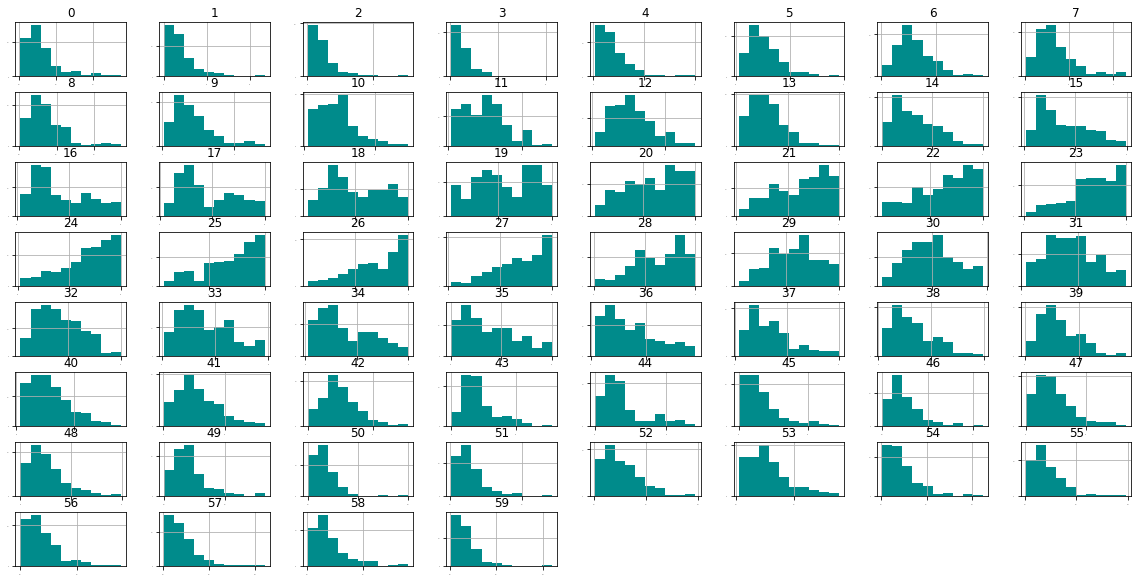

In [6]:
# Histogram plots of attributes
df.hist(figsize=(20,10), xlabelsize = 1, ylabelsize = 1, color = 'darkcyan');

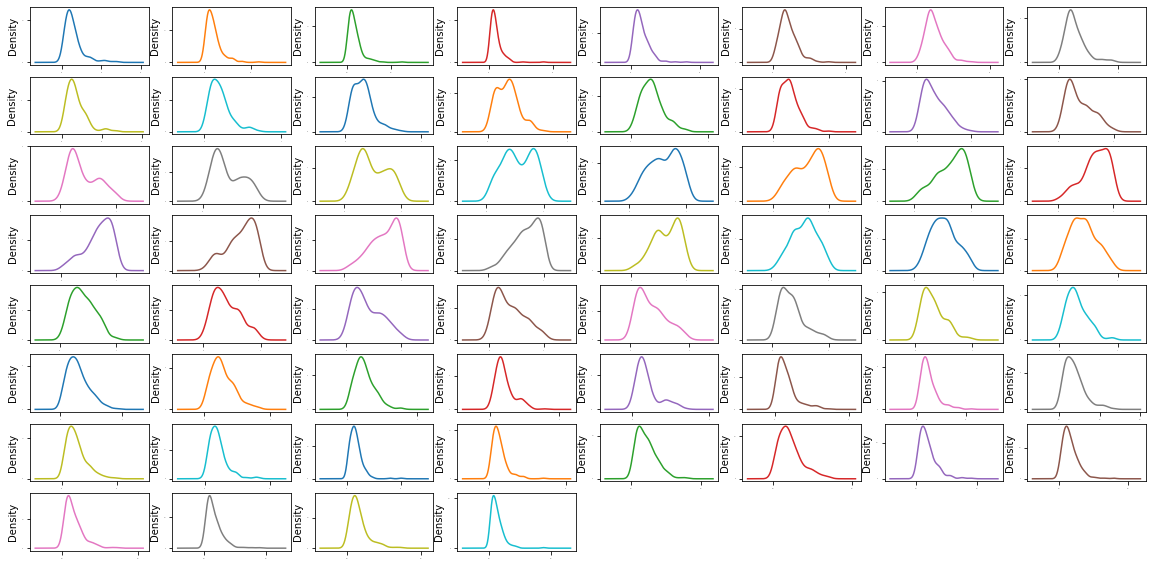

In [7]:
# Density plots of attributes
df.plot(kind = 'density', figsize=(20, 10), subplots = True, layout = (8,8), sharex = False, legend = False, fontsize = 1)
plt.title('Denisty Plots of Attributes\n', color = '#3f8088', y=1.03)
plt.show();

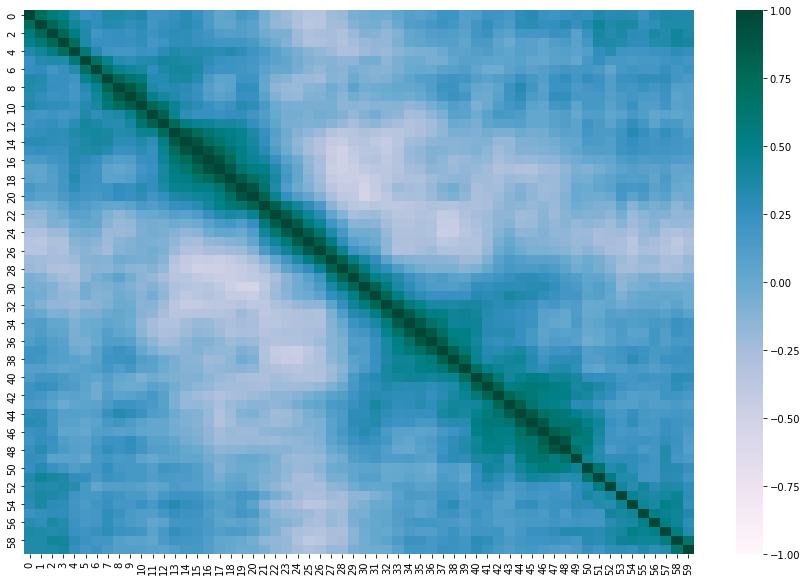

In [8]:
# Correlation matrix
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(), vmin = -1, vmax= 1, cmap =  'PuBuGn');     
           

<a id = 'title-four'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Data Validation </center></h1> 

In [9]:
# Split-out validation dataset
array = df.values
X = array[:, 0:60].astype(float)
y = array[:, 60]

X_train, X_val, y_train, y_val = split(X, y, test_size = 0.2, random_state = 1235)

<a id = 'title-five'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Evaluate Algorithms: Baseline </center></h1> 

In [10]:
# Test options and evaluation metric
num_folds = 10
scoring = 'accuracy'

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
 #### **Linear Algorithms:**

- Logistic Regression (LA)
- Liniar Discriminant Analysis (LDA)

#### **Nonlinear algorithms:**

- Classification and Regression Tree (CART)
- Support Vector Machine (SVM)
- Gaussian Naive Bayes (NB)
- K-Nearest Neighbors (KNN) 

In [11]:
# Prepare algorithms to evaluate
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The algorithms all use default tuning parameters. Let’s compare the algorithms. We will display the mean and standard deviation of accuracy for each algorithm as we calculate it and collect the results for use later.

In [12]:
# Evaluate algorithms using the test harness
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state = 1235, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = 'Model %s:   mean: %f     std: %f' %(name, cv_results.mean(), cv_results.std())
    print(msg)
    

Model LR:   mean: 0.705882     std: 0.094893
Model LDA:   mean: 0.747426     std: 0.124491
Model KNN:   mean: 0.765809     std: 0.110564
Model CART:   mean: 0.691176     std: 0.095206
Model NB:   mean: 0.656985     std: 0.097715
Model SVM:   mean: 0.595956     std: 0.139942


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The results suggest that both Logistic Regression and k-Nearest Neighbors may be worth further study.

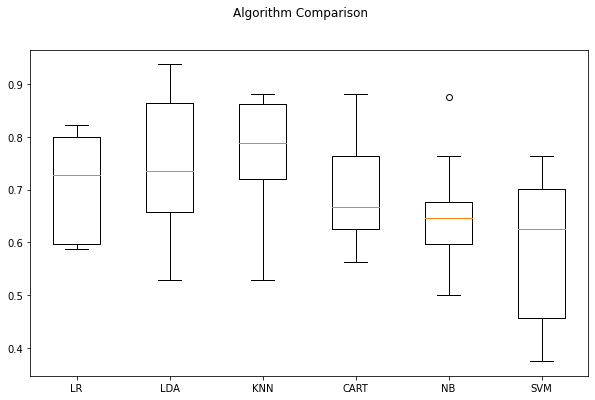

In [13]:
# Box and wisker plots of algorithm preformance
fig = plt.figure(figsize = (10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The results show a tight distribution for KNN which is encouraging, suggesting low variance. The poor results for SVM. 

    It is possible that the varied distribution of the attributes is having an effect on the accuracy of algorithms such as SVM. Let's repeat this spot-check with a standardized copy of the training dataset.

<a id = 'title-six'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Evaluate Algorithms: Standardize Data </center></h1> 

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
    Let’s evaluate the same algorithms with a standardized copy of the dataset. 
    This is where the data is transformed such that each attribute has a mean value of zero and a standard deviation of one. We also need to avoid data leakage when we transform the data. A good way to avoid leakage is to use pipelines that standardize the data and build the model for each fold in the cross-validation test harness. That way we can get a fair estimation of how each model with standardized data might perform on unseen data.



In [14]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(solver='liblinear'))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC(gamma='auto'))])))

# Evaluate algorithms on scaled dataset
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = 'Model %s:   mean: %f     std: %f' %(name, cv_results.mean(), cv_results.std())
    print(msg) 

Model ScaledLR:   mean: 0.723162     std: 0.107200
Model ScaledLDA:   mean: 0.747426     std: 0.124491
Model ScaledKNN:   mean: 0.802206     std: 0.090754
Model ScaledCART:   mean: 0.698529     std: 0.070814
Model ScaledNB:   mean: 0.656985     std: 0.097715
Model ScaledSVM:   mean: 0.796691     std: 0.077834


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    We can see that KNN is still doing well, even better than before. We can also see that the standardization of the data has lifted the skill of SVM to be the most accurate algorithm tested so far. 

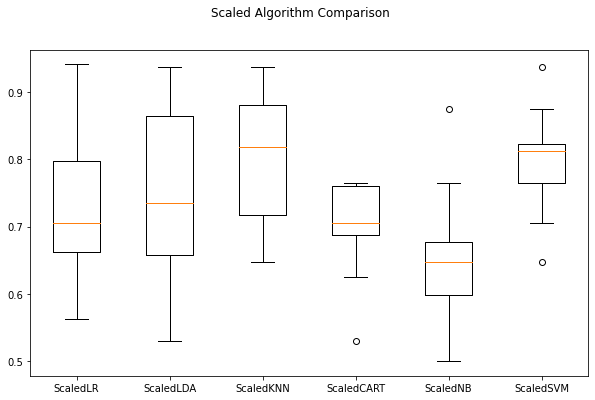

In [15]:
# Plot the distribution of algorithm performance on the scaled dataset
fig = plt.figure(figsize = (10,6))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The results suggest digging deeper into the SVM and KNN algorithms. It is very likely that configuration beyond the default may yield even more accurate models. 

<a id = 'title-seven'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Algorithm Tuning </center></h1> 

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
    Let's investigate tuning the parameters for two algorithms that show promise from the spot-checking in the previous section: KNN and SVM.
    The default number of neighbors is 7. Below we try all odd values of k from 1 to 21, covering the default value of 7. Each k-value is evaluated using 10-fold cross-validation on the training standardized dataset.

In [16]:
# Tuning scaled KNN
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
neighbors = [1,3,5,7,9,11,13,15,17,19,21]
param_grid = dict(n_neighbors = neighbors)
model = KNeighborsClassifier()
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid, 
                    scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, y_train)
print('Best: %f usinf %s' % (grid_result.best_score_, 
                             grid_result.best_params_))


means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Best: 0.880147 usinf {'n_neighbors': 1}
0.880147 (0.058158) with: {'n_neighbors': 1}
0.844118 (0.087947) with: {'n_neighbors': 3}
0.808088 (0.093801) with: {'n_neighbors': 5}
0.765074 (0.073519) with: {'n_neighbors': 7}
0.754044 (0.101838) with: {'n_neighbors': 9}
0.693015 (0.102958) with: {'n_neighbors': 11}
0.674632 (0.110260) with: {'n_neighbors': 13}
0.686765 (0.098167) with: {'n_neighbors': 15}
0.693382 (0.111503) with: {'n_neighbors': 17}
0.711765 (0.120487) with: {'n_neighbors': 19}
0.705515 (0.123175) with: {'n_neighbors': 21}


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    We can see that the optimal configuration is K=1 with accuracy 88.0147%.
    
    We can tune two key parameters of the SVM algorithm, the value of C (how much to relax the margin) and the type of kernel. The default for SVM (the SVC class) is to use the Radial Basis Function (RBF) kernel with a C value set to 1.0. Like with KNN, we will perform a grid search using 10-fold cross-validation with a standardized copy of the training dataset. We will try a number of simpler kernel types and C values with less bias and more bias (less than and more than 1.0 respectively).

In [17]:
# Tuning scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C = c_values, kernel = kernel_values)
model = SVC(gamma = 'auto')
kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
grid = GridSearchCV(estimator = model, param_grid = param_grid,
                    scoring = scoring, cv = kfold)
grid_result = grid.fit(rescaledX, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param)) 

Best: 0.844853 using {'C': 2.0, 'kernel': 'rbf'}
0.722426 (0.078564) with: {'C': 0.1, 'kernel': 'linear'}
0.541176 (0.155292) with: {'C': 0.1, 'kernel': 'poly'}
0.541544 (0.102587) with: {'C': 0.1, 'kernel': 'rbf'}
0.674632 (0.126390) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.734926 (0.114508) with: {'C': 0.3, 'kernel': 'linear'}
0.632353 (0.115103) with: {'C': 0.3, 'kernel': 'poly'}
0.735662 (0.112291) with: {'C': 0.3, 'kernel': 'rbf'}
0.717647 (0.094161) with: {'C': 0.3, 'kernel': 'sigmoid'}
0.729044 (0.110062) with: {'C': 0.5, 'kernel': 'linear'}
0.722794 (0.113259) with: {'C': 0.5, 'kernel': 'poly'}
0.759191 (0.106519) with: {'C': 0.5, 'kernel': 'rbf'}
0.735294 (0.109396) with: {'C': 0.5, 'kernel': 'sigmoid'}
0.716912 (0.106858) with: {'C': 0.7, 'kernel': 'linear'}
0.759559 (0.110725) with: {'C': 0.7, 'kernel': 'poly'}
0.771691 (0.098313) with: {'C': 0.7, 'kernel': 'rbf'}
0.740809 (0.106595) with: {'C': 0.7, 'kernel': 'sigmoid'}
0.734926 (0.101266) with: {'C': 0.9, 'kernel': 'linear'

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    We can see the most accurate configuration was SVM with an RBF kernel and a C = 2.0 with accuracy 84.4853%

<a id = 'title-eight'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Ensemble Methods </center></h1> 

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
Another way that we can improve the performance of algorithms on this problem is by using
ensemble methods. Let's evaluate four different ensemble machine learning
algorithms:

#### **Boosting Methods:**
- AdaBoost (AB)
- Gradient Boosting(GBM)

#### **Bagging Methods:**
- Random Forest (RF)
- Extra Trees (ET)

We will use the same test harness as before, 10-fold cross-validation. 
No data standardization is used in this case because all four ensemble algorithms are based on decision trees that are
less sensitive to data distributions.


In [18]:
# Ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier(n_estimators=10)))
ensembles.append(('ET', ExtraTreesClassifier(n_estimators=10)))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits = num_folds, random_state = 1235, shuffle = True)
    cv_results = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.758088 (0.098359)
GBM: 0.788971 (0.072664)
RF: 0.806985 (0.084531)
ET: 0.795956 (0.101769)


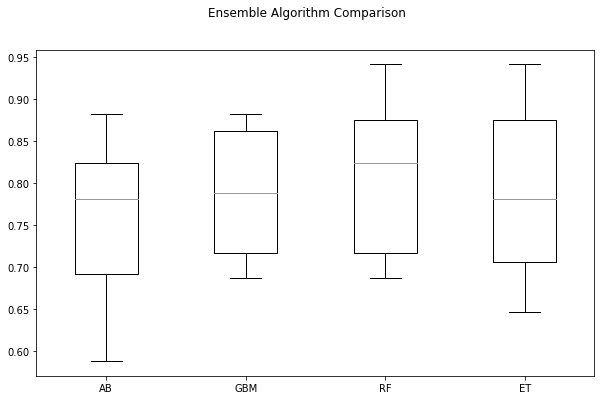

In [19]:
# Compare Algorithms
fig = plt.figure(figsize = (10,6))
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The results suggest GBM may be worthy of further study, with a strong mean and a spread that skews up towards high 90s (%) in accuracy.

<a id = 'title-nine'></a>
<h1 style='border-radius:10px; background-color:#3f8088; font-size:180%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'><center> Final Model </center></h1> 

In [20]:
# Prepare SVC model 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = SVC(gamma ='auto', C = 2.0)
model.fit(rescaledX, y_train)

# Estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_val)
predictions = model.predict(rescaledValidationX)
print('Accuracy: ', accuracy_score(y_val, predictions))
print('Confusion matrix: \n', confusion_matrix(y_val, predictions))
print('Classification report: \n', classification_report(y_val, predictions))

Accuracy:  0.9047619047619048
Confusion matrix: 
 [[22  2]
 [ 2 16]]
Classification report: 
               precision    recall  f1-score   support

           M       0.92      0.92      0.92        24
           R       0.89      0.89      0.89        18

    accuracy                           0.90        42
   macro avg       0.90      0.90      0.90        42
weighted avg       0.90      0.90      0.90        42



<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #3f8088;
            letter-spacing:0.5px;
            font-family: Cursive; 
            font-size:16px;
            padding: 10px;">
    
_👀 **Observations:**_

    The SVM showed the most promise as low complexity and stable model for this problem.

*** 

<p><center style="color:#3f8088; font-style:italic; font-family:Cursive;">Thanks for visiting my notebook </center></p>


<h1 style='border-radius:10px; background-color:#3f8088; font-size:200%; color:#b9f6f6; text-align: center; font-style:italic; font-family: Cursive'>
    👍If you find this notebook useful, I would appreciate an upvote!👍</h1>
    
<br><center><img src='https://media.giphy.com/media/hpXdHPfFI5wTABdDx9/giphy.gif' 
     height=30px width=160px /></center></br>

In [21]:
from IPython.display import display, HTML
c1,c2,f1,f2,fs1,fs2=\
'#46b0a9','#3f8088','Akronim','Smokum',30,10
def dhtml(string,fontcolor=c1,font=f1,fontsize=fs1):
    display(HTML("""<style>@import 
                'https://fonts.googleapis.com/css?family="""\
                +font+"""&effect=3d-float';</style>
                <h1 class='font-effect-3d-float'; 
                style='font-family:"""+\
                font+"""; color:"""+fontcolor+"""; 
                font-size:"""+\
                str(fontsize)+"""px;'>%s</h1>"""%string))
dhtml('Made with ❤️')
